In [15]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import requests
from bs4 import BeautifulSoup
from textblob import TextBlob
import scipy.stats as stats

In [16]:
def download_stock_data(ticker, start_date, end_date):
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    return stock_data

In [17]:
def preprocess_stock_data(stock_data):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_stock_data = scaler.fit_transform(stock_data['Close'].values.reshape(-1, 1))
    return scaled_stock_data, scaler

In [18]:
def create_train_test_datasets(scaled_stock_data, look_back_days):
    x_train, y_train = [], []
    for i in range(look_back_days, len(scaled_stock_data)):
        x_train.append(scaled_stock_data[i - look_back_days:i, 0])
        y_train.append(scaled_stock_data[i, 0])
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    return x_train, y_train

In [19]:
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(input_shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [20]:
def fetch_sentiment_from_news(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    headlines = soup.find_all('h3', class_='Mb(5px)')
    sentiments = [TextBlob(headline.get_text()).sentiment.polarity for headline in headlines]
    if sentiments:
        average_sentiment = np.mean(sentiments)
    else:
        average_sentiment = 0
    return average_sentiment

url = 'https://finance.yahoo.com/quote/JPM/news?p=JPM'
sentiment_score = fetch_sentiment_from_news(url)
print(f'Debug: Fetched sentiment score is {sentiment_score}')

Debug: Fetched sentiment score is 0


In [21]:
def calculate_mean_reversion(stock_data, window=20):
    rolling_mean = stock_data['Close'].rolling(window=window).mean()
    mean_reversion_signal = stock_data['Close'] - rolling_mean
    return mean_reversion_signal

In [22]:
def calculate_momentum(stock_data, window=20):
    momentum_signal = stock_data['Close'].pct_change(periods=window)
    return momentum_signal

In [23]:
def plot_stock_predictions(actual_prices, predicted_prices):
    plt.figure(figsize=(14,5))
    plt.plot(actual_prices, color='blue', label='Actual JPM Stock Price')
    plt.plot(predicted_prices, color='red', label='Predicted JPM Stock Price')
    plt.title('JPM Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

[*********************100%%**********************]  1 of 1 completed


Epoch 1/25
124/124 [==============================] - 12s 54ms/step - loss: 0.0095
Epoch 2/25
124/124 [==============================] - 7s 54ms/step - loss: 0.0026
Epoch 3/25
124/124 [==============================] - 7s 56ms/step - loss: 0.0026
Epoch 4/25
124/124 [==============================] - 7s 53ms/step - loss: 0.0022
Epoch 5/25
124/124 [==============================] - 7s 55ms/step - loss: 0.0021
Epoch 6/25
124/124 [==============================] - 7s 55ms/step - loss: 0.0018
Epoch 7/25
124/124 [==============================] - 7s 54ms/step - loss: 0.0017
Epoch 8/25
124/124 [==============================] - 7s 55ms/step - loss: 0.0018
Epoch 9/25
124/124 [==============================] - 7s 55ms/step - loss: 0.0016
Epoch 10/25
124/124 [==============================] - 7s 53ms/step - loss: 0.0016
Epoch 11/25
124/124 [==============================] - 7s 56ms/step - loss: 0.0014
Epoch 12/25
124/124 [==============================] - 7s 56ms/step - loss: 0.0014
Epoch 13/25


[*********************100%%**********************]  1 of 1 completed


3/3 [==============================] - 1s 21ms/step


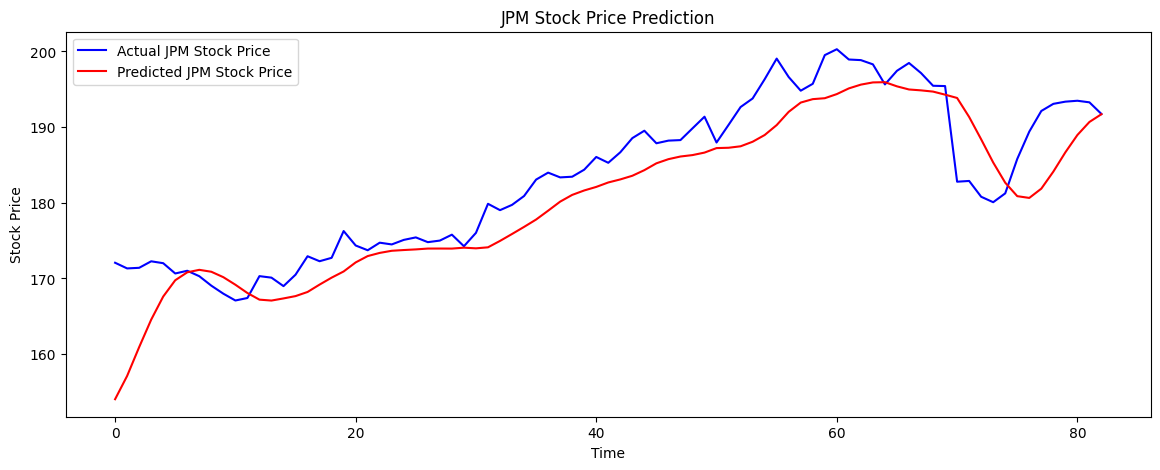

Average sentiment score: 0
Recent Mean Reversion Signals: Date
2023-11-24    7.518994
2023-11-27    6.294003
2023-11-28    5.837994
2023-11-29    5.855008
2023-11-30    6.758002
Name: Close, dtype: float64
Recent Momentum Signals: Date
2023-11-24    0.090793
2023-11-27    0.128970
2023-11-28    0.117305
2023-11-29    0.109737
2023-11-30    0.123363
Name: Close, dtype: float64


In [24]:
def main():

    ticker = 'JPM'
    start_date = '2008-01-01'
    end_date = '2023-12-01'
    look_back_days = 60
    sentiment_url = 'https://finance.yahoo.com/quote/JPM/news?p=JPM'

    stock_data = download_stock_data(ticker, start_date, end_date)
    scaled_stock_data, scaler = preprocess_stock_data(stock_data)
    x_train, y_train = create_train_test_datasets(scaled_stock_data, look_back_days)

    lstm_model = build_lstm_model(x_train.shape)
    lstm_model.fit(x_train, y_train, epochs=25, batch_size=32)

    test_start_date = '2024-01-01'
    test_end_date = '2024-05-01'
    test_stock_data = download_stock_data(ticker, test_start_date, test_end_date)
    actual_test_prices = test_stock_data['Close'].values

    total_dataset = pd.concat((stock_data['Close'], test_stock_data['Close']), axis=0)
    model_inputs = total_dataset[len(total_dataset) - len(test_stock_data) - look_back_days:].values
    model_inputs = model_inputs.reshape(-1, 1)
    model_inputs = scaler.transform(model_inputs)

    x_test = []
    for i in range(look_back_days, len(model_inputs)):
        x_test.append(model_inputs[i - look_back_days:i, 0])
    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    predicted_test_prices = lstm_model.predict(x_test)
    predicted_test_prices = scaler.inverse_transform(predicted_test_prices)

    plot_stock_predictions(actual_test_prices, predicted_test_prices)

    sentiment_score = fetch_sentiment_from_news(sentiment_url)
    print(f'Average sentiment score: {sentiment_score}')

    mean_reversion_signals = calculate_mean_reversion(stock_data)
    print('Recent Mean Reversion Signals:', mean_reversion_signals.tail())

    momentum_signals = calculate_momentum(stock_data)
    print('Recent Momentum Signals:', momentum_signals.tail())

if __name__ == "__main__":
    main()